# Project 3 - Text Generation

BookCorpus Dataset: Large	dataset	of	fiction	books,	suitable	for	long-form	storytelling.

In [ ]:
from datasets import load_dataset, Dataset 
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer 
from sklearn.model_selection import train_test_split 
import torch 

c:\Users\samys\Documents\Software\Anaconda\envs\MineriaTextos\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In [ ]:
ds = load_dataset("Saibo-creator/bookcorpus_deduplicated_small")

# Explore the dataset
print("Dataset structure:", ds) 
print("\nFirst example:", ds["train"][0]) 
print("\nColumn names:", ds["train"].column_names) 

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 100000
    })
})

First example: {'text': 'usually , he would be tearing around the living room , playing with his toys .'}

Column names: ['text']


Este dataset normalmente trae un campo:

"text"

## Part 1 - Preprocessing

Since it is not a conversational dataset, we generate sequential pairs by chunking:

prompt = chunk i

response = chunk i+1

In [ ]:
# Divide the text into chunks
def split_into_chunks(text, chunk_size=300, overlap=50): 
    chunks = []  # List to store the generated chunks
    start = 0 # Initial index for the chunk
    
    while start < len(text):  # Continues until the end of the text
        end = start + chunk_size # Calculate the end index of the chunk
        chunk = text[start:end].strip() # Extract the chunk and remove leading/trailing whitespace
        
        # Minimum length check
        if len(chunk) >= 50: 
            chunks.append(chunk)
        
        # Move the start index for the next chunk
        start += chunk_size - overlap  
        
    return chunks


Crear pares prompt-response

In [ ]:
pairs = [] # Lista donde se guardarán los pares (prompt, response)

for item in ds["train"]:     # Itera sobre cada ejemplo del split 'train' del dataset
    text = item["text"].strip()  # Obtiene el texto del ejemplo y elimina espacios extras
    
    paragraphs = split_into_chunks(text)  # Divide el texto en chunks o párrafos con la función definida antes
    
    # Crear pares consecutivos de párrafos
    for i in range(len(paragraphs) - 1):  # Recorre los chunks de forma que cada uno tenga un siguiente
        if len(paragraphs[i]) > 50 and len(paragraphs[i+1]) > 50:   # Asegura que ambos chunks tengan una longitud mínima
            pairs.append({   # Agrega un nuevo par a la lista
                "prompt": paragraphs[i],  # El chunk actual será el prompt
                "response": paragraphs[i+1]  # El chunk siguiente será la respuesta
            })

print(f"Total de pares creados: {len(pairs)}") # Imprime cuántos pares (prompt-response) se generaron
print("\nPrimeros 3 pares:") # Muestra una vista previa de los primeros 3 pares

for i, pair in enumerate(pairs[:3]):  # Itera sobre los 3 primeros pares
    print(f"\n--- Par {i+1} ---")  # Encabezado identificando el número del par
    print(f"Prompt: {pair['prompt'][:100]}...")                # Imprime los primeros 100 caracteres del prompt
    print(f"Response: {pair['response'][:100]}...")            # Imprime los primeros 100 caracteres de la response

Total de pares creados: 86

Primeros 3 pares:

--- Par 1 ---
Prompt: i guess it was n't just the speculation that had sent him over the edge , but the fact that there wa...
Response: did n't sit well with trace to see his woman as he put it , lip locked with some other dick ....

--- Par 2 ---
Prompt: no wonder i did n't recognize him at first-emerson 's transformed from a grungy , angry teenage boy ...
Response: pes of my new position , and who clearly was n't briefed on the fact that i , abby rowan , was going...

--- Par 3 ---
Prompt: with reflexes honed from long hours in military training and an innate sense that women should be pr...
Response: lding he had been about to enter only minutes earlier for business meetings ....


### Train test split

In [ ]:
# Dividir los pares en conjuntos de entrenamiento y validación, 90% y 10% respectivamente, usando una semilla fija para reproducibilidad
train_pairs, val_pairs = train_test_split(pairs, test_size=0.1, random_state=42)

# Cuantos pares hay en cada conjunto
print(f"Pares de entrenamiento: {len(train_pairs)}")
print(f"Pares de validación: {len(val_pairs)}")

Pares de entrenamiento: 77
Pares de validación: 9


### Tokenize using a Hugging Face Tokenizer

Load Tokenizer

In [ ]:
# Configurar el tokenizador GPT-2 desde HuggingFace y establecer el token de padding, ya que GPT-2 no tiene uno por defecto
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Usamos el token de fin de secuencia como token de padding
tokenizer.pad_token = tokenizer.eos_token

Tokenizer function (prompt + response juntos)

In [ ]:
def tokenize_prompt_response(example): # Define una función para tokenizar los pares prompt-response
    """Tokeniza los pares prompt-response""" 
    text = (
        "Continue the story:\n" 
        f"\"{example['prompt']}\"\n\n"
        f"Next part: {example['response']}"
        + tokenizer.eos_token
    )
    
    return tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors=None
    )


Lo que hicimos anteriormente fue:
* Construimos el texto final que se le dará al modelo
    - Instrucción inicial ("Continue the story:")
    - Prompt (fragmento anterior)
    - Respuesta (fragmento siguiente)
    - Un token EOS al final para marcar cierre del ejemplo.

Después 
* Tokenizamos el texto completo:
    - truncation: corta si excede max_length
    - padding: asegura longitud fija (max_length)
    - max_length: define tamaño de secuencia para el modelo
    - return_tensors: None → devuelve sólo diccionarios Python (no tensores)

In [ ]:
train_dataset = Dataset.from_list(train_pairs) # Crea un dataset de HuggingFace a partir de la lista de pares de entrenamiento
val_dataset = Dataset.from_list(val_pairs)

# Aplica la tokenización a cada par en el dataset de entrenamiento
# batched=False indica que se procesa un ejemplo a la vez y remove_columns elimina columnas y nos deja únicamente los tensores tokenizados para el modelo.
tokenized_train = train_dataset.map(tokenize_prompt_response, batched=False, remove_columns=train_dataset.column_names)

tokenized_val = val_dataset.map(tokenize_prompt_response, batched=False, remove_columns=val_dataset.column_names) # Tokenización del conjunto de validación con los mismos parámetros

Map: 100%|██████████| 9/9 [00:00<00:00, 481.04 examples/s]


In [ ]:
print("\n=== VERIFICACIÓN FINAL ===") # Imprime un encabezado visual para indicar el inicio de la verificación
print(f"Dataset de entrenamiento tokenizado: {len(tokenized_train)} ejemplos") # Muestra cuántos ejemplos tiene el dataset tokenizado de entrenamiento y nos ayuda a verificar que .map() funcionó correctamente
print(f"Dataset de validación tokenizado: {len(tokenized_val)} ejemplos") # Muestra cuántos ejemplos tiene el dataset tokenizado de validación, nos deja comprobar que todo esté en orden



=== VERIFICACIÓN FINAL ===
Dataset de entrenamiento tokenizado: 77 ejemplos
Dataset de validación tokenizado: 9 ejemplos


In [ ]:
# Mostrar un ejemplo tokenizado
sample = tokenized_train[0] # Obtiene el primer ejemplo del dataset tokenizado del dataset
print(f"\nEjemplo de input_ids (primeros 20 tokens): {sample['input_ids'][:20]}") # Muestra los primeros 20 IDs de tokens del input
print(f"Longitud del input: {len(sample['input_ids'])}") # Imprime la longitud total de la secuencia
    
# Decodificar para verificar
decoded_text = tokenizer.decode(sample['input_ids'], skip_special_tokens=False) # es la secuencia completa de IDs y mantenemos los tokens especiales
print(f"\nTexto decodificado (primeros 200 caracteres):\n{decoded_text[:200]}...") # Muestra los primeros 200 caracteres del texto reconstruido


Ejemplo de input_ids (primeros 20 tokens): [29453, 262, 1621, 25, 198, 1, 9, 1635, 1635, 1635, 1635, 618, 307, 8466, 5047, 832, 262, 3420, 262, 1708]
Longitud del input: 512

Texto decodificado (primeros 200 caracteres):
Continue the story:
"* * * * * when bella charged through the door the following morning , late and disheveled , still twisting her unruly blonde hair into a ponytail , her cowboy hat-a tan affair she...


## Parte 2 - Model Set Up

In [ ]:
# Cargar el modelo pre-entrenado
from transformers import AutoModelForCausalLM, DataCollatorForLanguageModeling

model = AutoModelForCausalLM.from_pretrained("gpt2") # Carga el modelo GPT-2 preentrenado desde HuggingFace
print(f"Modelo cargado: {model.config.model_type}") # Imprime el tipo de modelo cargado
print(f"Número de parámetros: {model.num_parameters():,}") # Imprime el número total de parámetros del modelo
print(f"Tamaño del vocabulario: {model.config.vocab_size}") # muestra el tamaño del vocabulario del modelo que es el total de tokens que puede manejar  

c:\Users\samys\Documents\Software\Anaconda\envs\MineriaTextos\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\samys\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Modelo cargado: gpt2
Número de parámetros: 124,439,808
Tamaño del vocabulario: 50257


In [ ]:
# Configurar data collator para language modeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, # Usar el tokenizador configurado 
    mlm=False,  # No usar masked language modeling para GPT-2
    return_tensors="pt" # indica que los tensores devueltos serán de PyTorch
)

In [ ]:
# Configurar argumentos de entrenamiento con early stopping
training_args = TrainingArguments(
    output_dir="./story_generator", # Carpeta donde se guardarán los modelos y checkpoints
    overwrite_output_dir=True, # Permite sobrescribir el contenido del directorio de salida
    num_train_epochs=3,  # Número reducido de épocas para CPU
    per_device_train_batch_size=2,  # Batch pequeño para evitar OOM
    per_device_eval_batch_size=2, # Batch pequeño para evaluación
    gradient_accumulation_steps=4,  # Acumular gradientes para batch efectivo de 8
    warmup_steps=100, # pasos de calentamiento para el scheduler de learning rate
    logging_steps=50, # cada 50 pasos se imprime datos de entrenamiento
    eval_steps=200, # cada 200 pasos se realiza evaluación
    save_steps=400, # cada 400 pasos se guarda un checkpoint
    eval_strategy="steps", # Realizar evaluación cada eval_steps
    logging_dir="./logs", # Directorio para guardar los logs de entrenamiento
    load_best_model_at_end=True, # recupera el mejor modelo al final del entrenamiento
    metric_for_best_model="eval_loss", # metrica usada para determinar el mejor modelo
    greater_is_better=False, # para eval_loss, menor es mejor
    save_total_limit=2,  # Guardar solo los 2 mejores modelos
    prediction_loss_only=True, # Solo calcular la pérdida durante la evaluación para ahorrar memoria
    report_to=None,  # Deshabilitar reporting externo
    # Configuraciones para ahorrar memoria en CPU
    dataloader_pin_memory=False, # Deshabilitar pin_memory si no es util en CPU
    remove_unused_columns=True, # Elimina columnas no usadas en el dataset
)

In [ ]:
# Crear Trainer con early stopping
trainer = Trainer( 
    model=model, # el modelo se entrenar
    args=training_args, # Configuraciones de entrenamiento
    data_collator=data_collator, # prepara los batches de datos para causal language modeling
    train_dataset=tokenized_train, # conjunto de datos de entrenamiento tokenizado
    eval_dataset=tokenized_val, # conjunto de datos de validación tokenizado
    tokenizer=tokenizer, # tokenizer para que el Trainer lo use al preparar los datos
)

C:\Users\samys\AppData\Local\Temp\ipykernel_2756\2899434582.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Evaluación previa al entrenamiento (modelo pre-entrenado)

initial_eval = trainer.evaluate() # Evalúa el modelo antes de iniciar el entrenamiento
print(f"Pérdida inicial en validación: {initial_eval['eval_loss']:.4f}") # Imprime la pérdida inicial en el conjunto de validación

Pérdida inicial en validación: 4.2895


In [ ]:
# Entrenamiento del modelo
try:
    train_result = trainer.train() # Inicia el proceso de entrenamiento
    print("Entrenamiento completado") # Indica que el entrenamiento ha finalizado exitosamente
    
    # Mostrar métricas del entrenamiento
    print(f"\nMétricas finales:") # Imprime un encabezado para las métricas finales
    print(f"   - Pérdida final: {train_result.metrics['train_loss']:.4f}") # Imprime la pérdida final del entrenamiento
    print(f"   - Tiempo total: {train_result.metrics['train_runtime']:.2f} segundos") # Imprime el tiempo total de entrenamiento
    print(f"   - Samples por segundo: {train_result.metrics['train_samples_per_second']:.2f}") # Imprime la velocidad de entrenamiento en samples por segundo
    
# si algo malo pasa se captura el error y se muestra un mensaje    
except Exception as e:
    print(f"Error durante el entrenamiento: {e}")
    print("Intentando continuar con el modelo pre-entrenado...")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.


Step,Training Loss,Validation Loss


Entrenamiento completado

Métricas finales:
   - Pérdida final: 4.2090
   - Tiempo total: 6398.52 segundos
   - Samples por segundo: 0.04


In [ ]:
# Evaluación después del entrenamiento
final_eval = trainer.evaluate() # Evalúa el modelo después del entrenamiento
print(f"Pérdida final en validación: {final_eval['eval_loss']:.4f}") # Imprime la pérdida final en el conjunto de validación

Pérdida final en validación: 3.6839


In [ ]:
# Guardar el modelo entrenado (por si acaso)
trainer.save_model() # Guarda el modelo entrenado en el directorio de salida especificado en training_args
tokenizer.save_pretrained("./story_generator") # Guarda el tokenizer en la misma carpeta
print("Modelo y tokenizer guardados en './story_generator'") # Indica que el modelo y tokenizer se han guardado correctamente


Modelo y tokenizer guardados en './story_generator'


## Parte 3 - Generación y decodificación

In [2]:
# Cargar el modelo entrenado para generación

model_path = "./story_generator" # Ruta donde se guardó el modelo entrenado
generation_model = AutoModelForCausalLM.from_pretrained(model_path) # Carga el modelo entrenado desde la ruta especificada
generation_tokenizer = AutoTokenizer.from_pretrained(model_path) # Carga el tokenizer asociado al modelo entrenado

In [3]:
# Función para generar texto con diferentes estrategias
def generate_with_strategies(prompt, max_length=150, num_return_sequences=1): # Define una función para generar texto usando diferentes estrategias de decoding
    """
    Genera texto usando diferentes estrategias de decoding
    """
    # Tokenizar el prompt
    inputs = generation_tokenizer.encode(prompt, return_tensors="pt")
    
    strategies = {
        "Greedy Decoding": {
            "do_sample": False, # usar greedy decoding
            "num_beams": 1 # un solo beam
        },
        "Beam Search (beams=3)": { # usar beam search con 3 beams
            "do_sample": False, # usar beam search
            "num_beams": 3, # tres beams
            "early_stopping": True, # detenerse temprano si se alcanza la mejor secuencia
            "no_repeat_ngram_size": 2 # evitar repetir n-gramas
        },
        "Top-k Sampling (k=50)": {
            "do_sample": True, # usar sampling
            "top_k": 50, # limitar a los top 50 tokens
            "temperature": 0.7 # controlar aleatoriedad
        },
        "Nucleus Sampling (p=0.9)": {
            "do_sample": True, # usar sampling
            "top_p": 0.9, # limitar a los top p tokens
            "temperature": 0.7 # controlar aleatoriedad
        },
        "Beam Search + Sampling": {
            "do_sample": True, # combinar beam search con sampling
            "num_beams": 3, # tres beams
            "top_p": 0.9, # limitar a los top p tokens
            "temperature": 0.7 # controlar aleatoriedad
        }
    }
    
    print(f"Prompt: '{prompt}'\n") # Muestra el prompt usado para la generación
    print("=" * 80) # Visual separator
    
    generations = {} # Diccionario para almacenar las generaciones
    
    for strategy_name, params in strategies.items(): # Itera sobre cada estrategia definida
        print(f"\n🔹 {strategy_name}:")
        print("-" * 40)
        
        try:
            # Generar texto
            outputs = generation_model.generate(
                inputs, # input_ids del prompt tokenizado
                max_length=max_length, # longitud máxima de la secuencia generada
                pad_token_id=generation_tokenizer.eos_token_id, # token de padding
                num_return_sequences=num_return_sequences, # número de secuencias a generar
                **params # parámetros específicos de la estrategia
            )
            
            # Decodificar y mostrar resultados
            for i, output in enumerate(outputs): # Itera sobre cada secuencia generada
                generated_text = generation_tokenizer.decode(output, skip_special_tokens=True) # Decodifica la secuencia generada
                # Mostrar solo la parte generada (después del prompt) 
                generated_part = generated_text[len(prompt):].strip() # Extrae la parte generada eliminando el prompt
                print(f"   {generated_part}") # Imprime la parte generada
                
                generations[f"{strategy_name}_{i+1}"] = generated_part # Almacena la parte generada en el diccionario
                
        except Exception as e:
            print(f" Error: {e}") # Captura y muestra cualquier error durante la generación
    
    return generations


In [5]:
# Probar con diferentes prompts de historias
test_prompts = [
    "Once upon a time in a distant kingdom",
    "The old mansion at the end of the street was rumored to be",
    "As the spaceship entered the atmosphere, the captain noticed",
    "She opened the ancient book and discovered that",
    "In the year 2050, artificial intelligence had become"
]

print("Probando generación de texto con diferentes prompts y estrategias")
print("=" * 80)

all_generations = {} # Diccionario para almacenar todas las generaciones

for i, prompt in enumerate(test_prompts): # Itera sobre los prompts de prueba
    print(f"\nTEST {i+1}/{len(test_prompts)}") 
    generations = generate_with_strategies(prompt, max_length=120, num_return_sequences=1) # Genera texto para el prompt actual
    all_generations[prompt] = generations # Almacena las generaciones para el prompt actual
    print("\n" + "=" * 80) # Visual separator

Probando generación de texto con diferentes prompts y estrategias

TEST 1/5
Prompt: 'Once upon a time in a distant kingdom'


🔹 Greedy Decoding:
----------------------------------------
   , the king of the land, the king of the land, the king of the land, the king of the land, the king of the land, the king of the land, the king of the land, the king of the land, the king of the land, the king of the land, the king of the land, the king of the land, the king of the land, the king of the land, the king of the land, the king of the land, the king of the land, the king of the land, the king of

🔹 Beam Search (beams=3):
----------------------------------------
   , there was a man who had been born in the land of the dead, and had lived a long and prosperous life.

He was the son of a wealthy merchant, who lived on the banks of an ancient river. He had a wife and three children, all of whom were of noble birth. His father had died when he was twelve years old, but his mother had given bir

## Parte 4 - Evaluación

In [ ]:
from evaluate import load
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# cargar métricas
bleu = load("bleu") # métrica BLEU para evaluar calidad de texto generado
rouge = load("rouge") # métrica ROUGE para evaluar calidad de texto generado
perplexity = load("perplexity", module_type="metric") # métrica Perplexity para evaluar fluidez del texto generado

c:\Users\samys\Documents\Software\Anaconda\envs\MineriaTextos\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_path = "./story_generator" # Ruta donde se guardó el modelo entrenado
model = AutoModelForCausalLM.from_pretrained(model_path) # Carga el modelo entrenado desde la ruta especificada
tokenizer = AutoTokenizer.from_pretrained(model_path) # Carga el tokenizer asociado al modelo entrenado
tokenizer.pad_token = tokenizer.eos_token # Usamos el token de fin de secuencia como token de padding


In [ ]:
# Prompts de prueba
test_prompts = [
    "Once upon a time in a distant kingdom",
    "The old mansion at the end of the street was rumored to be",
    "As the spaceship entered the atmosphere, the captain noticed"
]


# Generar los textos para cada prompt y estrategia

all_generations = {}

for prompt in test_prompts: # Itera sobre los prompts de prueba
    inputs = tokenizer.encode(prompt, return_tensors="pt")
    
    strategies = {
        "Greedy Decoding_1": {"do_sample": False, "num_beams": 1},
        "Beam Search (beams=3)_1": {"do_sample": False, "num_beams": 3, "early_stopping": True},
        "Top-k Sampling (k=50)_1": {"do_sample": True, "top_k": 50, "temperature": 0.7},
        "Nucleus Sampling (p=0.9)_1": {"do_sample": True, "top_p": 0.9, "temperature": 0.7}
    }
    
    prompt_generations = {} # Diccionario para almacenar las generaciones del prompt actual
    for strategy_name, params in strategies.items(): # Itera sobre cada estrategia definida
        outputs = model.generate(
            inputs, # input_ids del prompt tokenizado
            max_length=150, # longitud máxima de la secuencia generada
            pad_token_id=tokenizer.eos_token_id, # token de padding
            **params # parámetros específicos de la estrategia
        )
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True) # Decodifica la secuencia generada
        prompt_generations[strategy_name] = generated_text[len(prompt):].strip() # Almacena la parte generada en el diccionario
    
    all_generations[prompt] = prompt_generations # Almacena las generaciones para el prompt actual

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [ ]:
# Calcular métricas automáticas
def calculate_automatic_metrics(generated_texts, reference_texts): # Define una función para calcular métricas automáticas
    metrics_results = {} # Diccionario para almacenar los resultados de las métricas
    
    # BLEU Score
    references = [[ref] for ref in reference_texts] # Formato requerido por la métrica BLEU
    bleu_result = bleu.compute(
        predictions=generated_texts[:len(references)],  # predicciones generadas
        references=references # referencias reales
    )
    metrics_results['bleu'] = bleu_result['bleu'] # Almacena el resultado BLEU
    
    # ROUGE Scores
    rouge_result = rouge.compute(
        predictions=generated_texts[:len(reference_texts)],  # predicciones generadas
        references=reference_texts[:len(generated_texts)] # referencias reales
    )
    metrics_results['rouge1'] = rouge_result['rouge1'] # Almacena el resultado ROUGE-1
    metrics_results['rouge2'] = rouge_result['rouge2'] 
    metrics_results['rougeL'] = rouge_result['rougeL']
    
    # Perplexity
    perplexity_result = perplexity.compute( # Calcula la perplexity
        predictions=generated_texts, # predicciones generadas
        model_id='gpt2' # modelo base para calcular perplexity
    )
    metrics_results['perplexity'] = perplexity_result['mean_perplexity'] # Almacena el resultado de perplexity
    
    # Cosine Similarity
    vectorizer = TfidfVectorizer().fit_transform(generated_texts + reference_texts[:len(generated_texts)]) # Vectorización TF-IDF
    vectors = vectorizer.toarray() # Convierte a array numpy
    gen_vectors = vectors[:len(generated_texts)] # vectores de textos generados
    
    ref_vectors = vectors[len(generated_texts):len(generated_texts)*2] # vectores de textos de referencia
    
    similarities = [] # Lista para almacenar similitudes
    for i in range(len(gen_vectors)): # Itera sobre cada vector generado
        if i < len(ref_vectors): # Asegura que haya un vector de referencia correspondiente
            sim = cosine_similarity([gen_vectors[i]], [ref_vectors[i]])[0][0] # Calcula la similitud coseno
            similarities.append(sim) # Agrega la similitud a la lista
    
    metrics_results['cosine_similarity'] = np.mean(similarities) if similarities else 0.0 # Almacena la similitud coseno promedio
    
    return metrics_results

In [ ]:
# Preparar datos para la evaluación
all_generated_texts = [] # Lista para almacenar todos los textos generados
strategy_names = [] # Lista para almacenar los nombres de las estrategias

for prompt in test_prompts:
    for strategy in ["Greedy Decoding_1", "Beam Search (beams=3)_1", "Top-k Sampling (k=50)_1", "Nucleus Sampling (p=0.9)_1"]: # Itera sobre cada estrategia
        if prompt in all_generations and strategy in all_generations[prompt]: # Verifica que exista la generación
            full_text = prompt + " " + all_generations[prompt][strategy] # Combina el prompt con el texto generado
            all_generated_texts.append(full_text) # Agrega el texto completo a la lista
            strategy_names.append(strategy.split('_')[0]) # Agrega el nombre de la estrategia a la lista

In [ ]:
# Calcular las métricas por estratégia
strategy_metrics = {} # Diccionario para almacenar métricas por estrategia
unique_strategies = list(set(strategy_names)) # Lista de estrategias únicas

for strategy in unique_strategies:
    print(f"Evaluating: {strategy}") # Muestra la estrategia que se está evaluando
    strategy_texts = [all_generated_texts[i] for i in range(len(all_generated_texts)) if strategy_names[i] == strategy] # Filtra los textos generados por estrategia
    
    if strategy_texts: # Si hay textos generados para esta estrategia
        metrics = calculate_automatic_metrics(strategy_texts, test_prompts[:len(strategy_texts)]) # Calcula las métricas automáticas
        strategy_metrics[strategy] = metrics # Almacena las métricas para la estrategia

print(f"Metrics calculated for {len(strategy_metrics)} strategies") # Indica cuántas estrategias fueron evaluadas

Evaluating: Top-k Sampling (k=50)


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Evaluating: Greedy Decoding


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Evaluating: Nucleus Sampling (p=0.9)


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Evaluating: Beam Search (beams=3)


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

Metrics calculated for 4 strategies


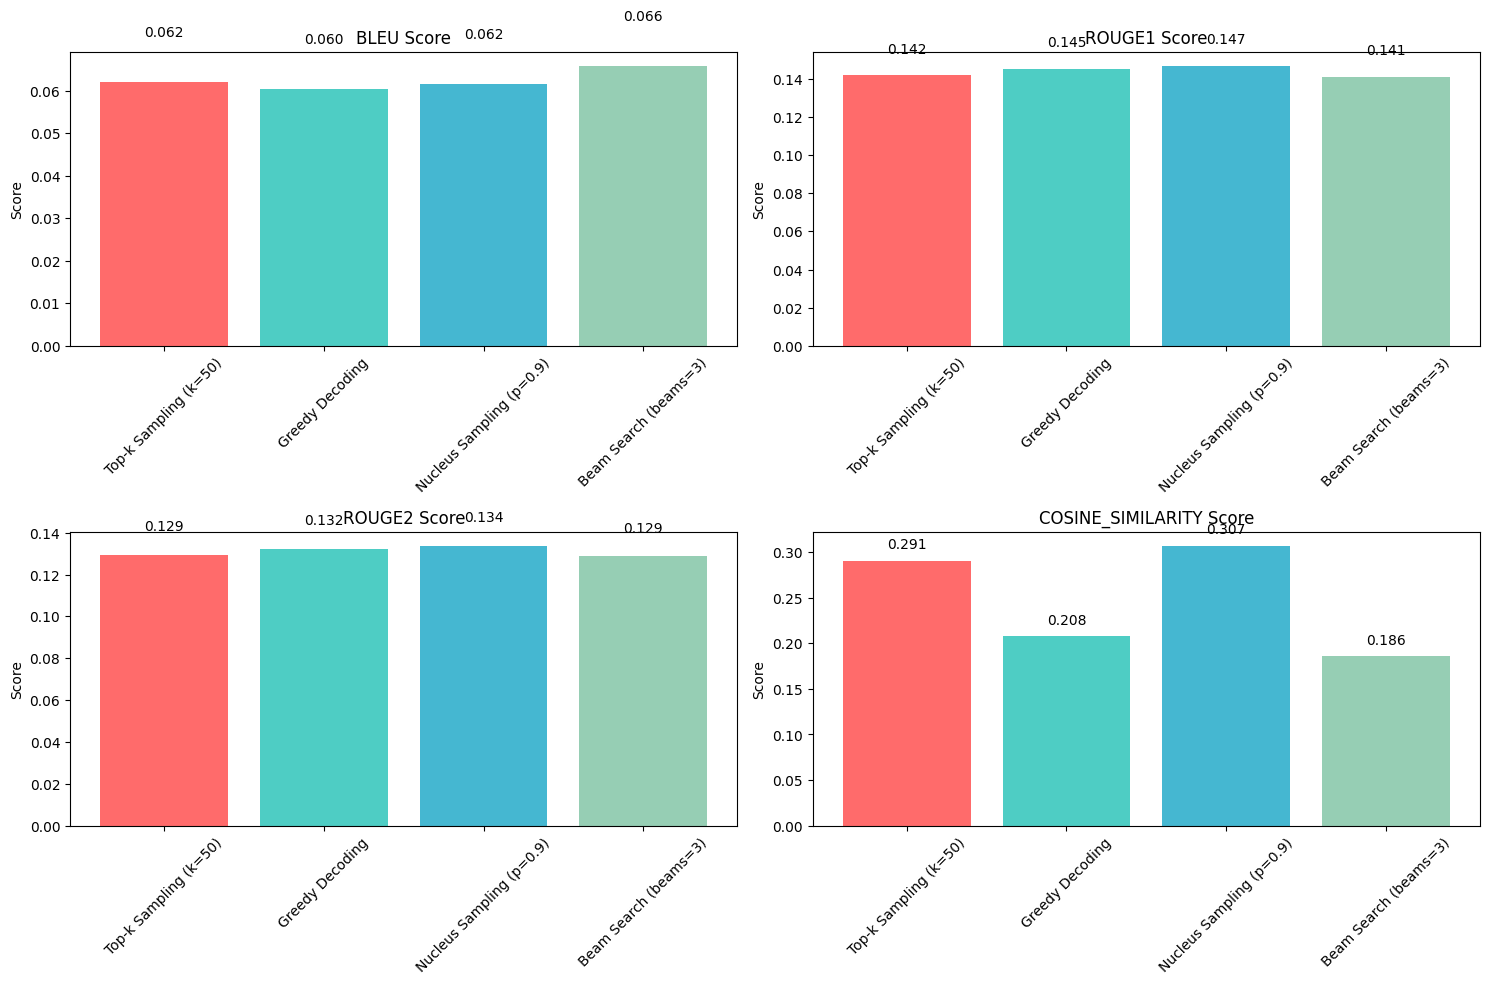

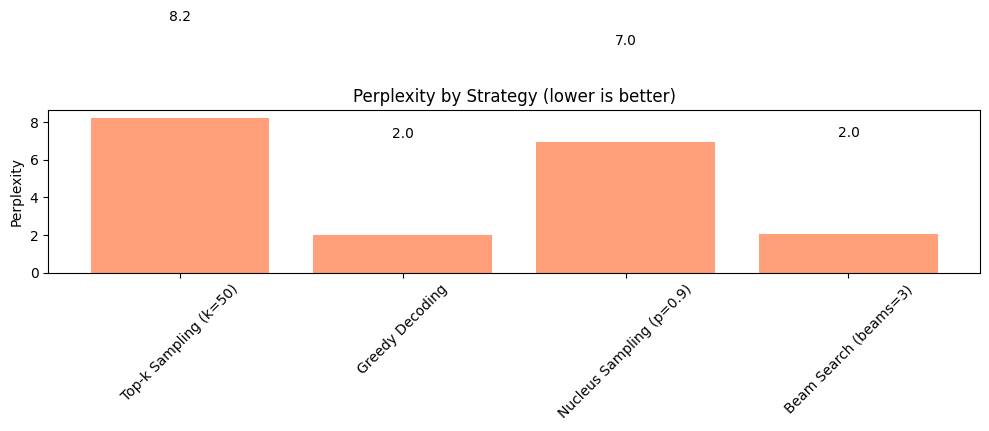

In [ ]:
# Visualización
if strategy_metrics:
    strategies = list(strategy_metrics.keys()) # Lista de estrategias evaluadas
    metrics_to_plot = ['bleu', 'rouge1', 'rouge2', 'cosine_similarity'] # Métricas a graficar
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10)) # Crear una figura con subplots
    axes = axes.flatten() # Aplanar los ejes para fácil iteración
    
    for i, metric in enumerate(metrics_to_plot): # Itera sobre cada métrica a graficar
        values = [strategy_metrics[strategy].get(metric, 0) for strategy in strategies] # Obtiene los valores de la métrica para cada estrategia
        axes[i].bar(strategies, values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']) # Colores personalizados para las barras
        axes[i].set_title(f'{metric.upper()} Score') 
        axes[i].set_ylabel('Score') 
        axes[i].tick_params(axis='x', rotation=45) 
        
        for j, v in enumerate(values):
            axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom') # Añadir etiquetas de valor encima de las barras
    
    plt.tight_layout()
    plt.show()
    
    # Plot de perplejidad
    plt.figure(figsize=(10, 6))
    perplexity_values = [strategy_metrics[strategy].get('perplexity', 100) for strategy in strategies]
    plt.bar(strategies, perplexity_values, color='#FFA07A')
    plt.title('Perplexity by Strategy (lower is better)')
    plt.ylabel('Perplexity')
    plt.xticks(rotation=45)
    
    for i, v in enumerate(perplexity_values):
        plt.text(i, v + 5, f'{v:.1f}', ha='center', va='bottom') # Añadir etiquetas de valor encima de las barras
    
    plt.tight_layout()
    plt.show()


## Parte 5 - Demo interactivo

In [6]:
# Función interactiva para probar prompts personalizados
def interactive_generation_demo(): # Define una función para una celda interactiva de generación de texto
    print("\nCELDA INTERACTIVA DE GENERACIÓN")
    print("=" * 60)
    print("Escribe tus propios prompts para generar historias!")
    print("Escribe 'quit' para salir\n")
    
    while True: # Bucle infinito hasta que el usuario decida salir
        user_prompt = input("Escribe tu prompt: ").strip()
        
        if user_prompt.lower() in ['quit', 'exit', 'salir']:
            print("Bye :)")
            break
            
        if not user_prompt:
            print("Por favor escribe un prompt válido\n")
            continue
            
        print("\nGenerando...")
        generate_with_strategies(user_prompt, max_length=100, num_return_sequences=1)
        print("\n" + "=" * 60)
        
interactive_generation_demo() # Llama a la función para iniciar la celda interactiva


CELDA INTERACTIVA DE GENERACIÓN
Escribe tus propios prompts para generar historias!
Escribe 'quit' para salir


Generando...
Prompt: 'A story about a princess and a frog'


🔹 Greedy Decoding:
----------------------------------------
   .

The story about a princess and a frog. The story about a frog and a frog. The story about a frog and a frog. The story about a frog and a frog. The story about a frog and a frog. The story about a frog and a frog. The story about a frog and a frog. The story about a frog and a frog. The story about a frog and a frog. The story about a frog and a frog

🔹 Beam Search (beams=3):
----------------------------------------
   .

The story of a girl and her frog, and how she got to be the princess of the world.


This story is about how a boy and his frog got together to become the king of all the land.

🔹 Top-k Sampling (k=50):
----------------------------------------
   who are both at the top of their game. I had to go back to the chapter where she was ta

Trabajar con modelos de machine learning no solo se trata de obtener buenas métricas, también implica una responsabilidad ética. Estos modelos aprenden de los datos, y si esos datos tienen sesgos, el modelo los va a reproducir, afectando potencialmente a personas de manera injusta. Además, muchas veces usamos modelos complejos sin entender del todo cómo llegan a sus predicciones, lo que hace importante ser transparentes sobre sus límites. En general, mientras más impacto tenga la aplicación del modelo, más cuidado debemos tener para asegurarnos de que sea justo, confiable y no se use de forma irresponsable.